# Quantum state tomography (QST) with Gradient descent (GD) 


## Using the method of Projective normalization


## Note 1:

For the GD methods it is necesary the library Jax (https://github.com/google/jax). Also QuTip is a very important library.

In [1]:
# To call the libraries for the GD-QST
import sys
sys.path.insert(0, '..')
# You have to change the path of the library 
import os


from qutip import * 
from itertools import *
import numpy as np
import matplotlib.pyplot as plt 
import qutip as qtp

from qst_tec.gdproj import gd_project, Nkets, softmax

import jax
import jax.numpy as jnp
import jax.numpy.linalg  as nlg
from jax import grad
from jax import jit
from jax.example_libraries import optimizers
from jax import config
config.update("jax_enable_x64", True) # We want float64 for better precision
import optax

from tqdm.auto import tqdm   # For the progressbars
import time

/home/mstorresh/anaconda3/envs/gd_qst_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### First we will define the number of qubits and the measurement operators. We will use the Pauli matrices.

In [2]:
number_qubits: int = 3
dimension: int = 2**number_qubits
HS: int = dimension


# Creating the Measurement operators (Pauli matrices)

pauli = [qeye(2), sigmax(), sigmay(), sigmaz()]
pauli_sys = [tensor(*op) for op in product(pauli, repeat=number_qubits)] # using itertools

Measu_ope = [Qobj(pauli_sys[i], dims=([[2**number_qubits], [2**number_qubits]])) for i in range(len(pauli_sys))]

print(Measu_ope[1:3])

#-----------------------------------------------------------------------
# It is necesary to transform the measurement operators from a numpy 
# type to a jax type (jax.np), that because of the jax grad 

ops_np = [op.full() for op in Measu_ope] # transforming from qutip object to numpy
ops_jnp = jnp.asarray(ops_np) # transforming from numpy to jax.np

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[Quantum object: dims=[[8], [8]], shape=(8, 8), type='oper', isherm=True
Qobj data =
[[0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]], Quantum object: dims=[[8], [8]], shape=(8, 8), type='oper', isherm=True
Qobj data =
[[0.+0.j 0.-1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.-1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.-1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+1.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.-1.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+1.j 0.+0.j]]]


## The ansatz


We need to create one array with the amplitudes of probabilities and other one with the value of probabilities for being in one state

$$\mathcal{C}_m = \begin{bmatrix} p_1 & \cdots & p_m \end{bmatrix}^T$$

$$\mathcal{Q}_m = \begin{bmatrix} \ket{\psi_1} & \cdots & \ket{\psi_m}  \end{bmatrix}^T$$


In [3]:
def ansatz(kn: int):
    """
    Creates the proper ansatz structure for the different GD methods
    
    Args: 
        kn (int) : rank number
    
    Output:
        ket_f, prob1_array_jnp : Ansatz GD-projective 
        
    """

    ketl1 = Nkets(kn, HS)   # generate kn random kets with hilbert space HS
    ketl1_np = [a.full() for a in ketl1]
    ketl2 = [a.full().flatten() for a in ketl1]
    ketl2_np = np.asarray(ketl2)
    ketl2_jnp = jnp.asarray(ketl2)
    ketl1_jnp = jnp.asarray(ketl1_np)
    prob1_array = np.random.rand(kn) # create the second list for the random probabilities
    prob1_array = softmax(prob1_array)
    prob1_array_jnp = jnp.asarray(prob1_array)
    
    # --- kets for GD proj -------------------------------------
    ket_f = ketl1_jnp.flatten()
    ket_f = ket_f[:, jnp.newaxis]

    
    return ket_f, prob1_array_jnp

Visualizing the structure of the ansatz (optional)

In [4]:
ket_f, prob1_array_jnp = ansatz(2)
print("ket array : ", ket_f)
print("ket array : ", prob1_array_jnp)


ket array :  [[ 0.15949375+0.2119445j ]
 [-0.28647019+0.22828479j]
 [ 0.10898612-0.01036125j]
 [ 0.05859652-0.42662138j]
 [-0.53471885+0.32798719j]
 [-0.01475942-0.21438247j]
 [ 0.03384414-0.21220304j]
 [-0.33143992+0.0482903j ]
 [ 0.04815918-0.10766801j]
 [ 0.19875759+0.08789268j]
 [-0.37921138+0.07310805j]
 [-0.4419264 -0.35967236j]
 [-0.43388332-0.0247006j ]
 [ 0.01717908-0.15038589j]
 [ 0.12350393-0.36004657j]
 [-0.16527358-0.28473036j]]
ket array :  [0.37829868 0.62170132]


## Implementing the GD projective

In [5]:
# List to save the values of fidelity and time for the GD methods
fid_list_proj = []
time_list_proj = []


max_itera: int = 300
batch_s = round(0.5*len(ops_jnp)) # The batch size, taking a group of measurement operators 

# creating the original densirty matrix, this with a random rho from QuTip
rho_or = rand_dm(2**number_qubits)
data = qtp.expect(Measu_ope,rho_or)

##-----------------GD-QST starts ---------------
# define rank of ansatz
rank = 2**number_qubits # maximum rank is 2**N
ket_f, prob1_array_jnp = ansatz(rank)

# GD-QST-projection
rho_gd_proj, f_gd_proj, t_gd_proj, loss_gd_proj = gd_project(data, rho_or, ops_jnp, ket_f, prob1_array_jnp, max_itera, batch_s,
                                                             lr=1e-1, decay=0.099, lamb=0, tqdm_off=False)
fid_list_proj.append(f_gd_proj)
time_list_proj.append(t_gd_proj)

Fidelity GD-projection 0.9999: 100%|██████████| 300/300 [00:03<00:00, 97.43it/s] 


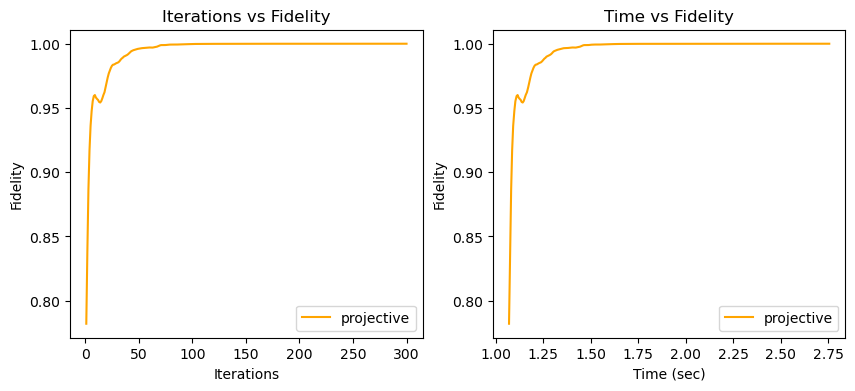

In [6]:
fid_list_proj = np.array(fid_list_proj)
mean_fid_proj = np.mean(fid_list_proj, axis=0)
time_list_proj = np.array(time_list_proj)
mean_time_proj = np.mean(time_list_proj, axis=0)


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))


###-------------Fidelity Vs iterations -------------#######

ax1.set_title("Iterations vs Fidelity", fontsize=12)

iterations = np.arange(1,len(f_gd_proj)+1)   # total number of iterations

ax1.plot(iterations, mean_fid_proj, color='orange',label="projective")

ax1.legend(loc='lower right')
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Fidelity")


###-------------Fidelity Vs time -------------#######

ax2.set_title("Time vs Fidelity", fontsize=12)


ax2.plot(mean_time_proj, mean_fid_proj, color='orange',label="projective")


ax2.legend(loc='lower right')
ax2.set_xlabel("Time (sec)")
ax2.set_ylabel("Fidelity")

plt.show()


In [7]:
print('max fidelity (chol_proj) and time in seconds:', [np.max(f_gd_proj), mean_time_proj[np.argmax(mean_fid_proj)]])


max fidelity (chol_proj) and time in seconds: [0.9998896193590517, 2.756650686264038]


## GHZ state
Now let's reconstruct a GHZ state
$$ \frac{|000\rangle + |111\rangle}{\sqrt{2}}$$

In [8]:
# Define the basis states |0> and |1> for a single qubit
zero = qtp.basis(2, 0)  # |0>
one = qtp.basis(2, 1)   # |1>

# Construct the |000> and |111> states for 3 qubits
state_000 = qtp.tensor(zero, zero, zero)  # |000>
state_111 = qtp.tensor(one, one, one)     # |111>

# Create the GHZ state: (|000> + |111>) / sqrt(2)
ghz_state = (state_000 + state_111).unit()
ghz_state = qtp.Qobj(ghz_state.full(), dims=[[8], [1]])  # Reshape the GHZ state to have dimensions [8]
# This reshape is necessary for the function qtp.expect. It will depend of the version of QuTip
 
print(ghz_state)

Quantum object: dims=[[8], [1]], shape=(8, 1), type='ket'
Qobj data =
[[0.70710678]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.70710678]]


In [9]:
# List to save the values of fidelity and time for the GD methods
fid_list_proj = []
time_list_proj = []


max_itera: int = 300
batch_s = round(0.5*len(ops_jnp)) # The batch size, taking a group of measurement operators 

rho_or = ghz_state
data = qtp.expect(Measu_ope,rho_or)

##-----------------GD-QST starts ---------------
# define rank of ansatz
rank = 1 # maximum rank is 2**N
ket_f, prob1_array_jnp = ansatz(rank)

# GD-QST-projection
rho_gd_proj, f_gd_proj, t_gd_proj, loss_gd_proj = gd_project(data, rho_or, ops_jnp, ket_f, prob1_array_jnp, max_itera, batch_s,
                                                             lr=9e-3, decay=0.999, lamb=0, tqdm_off=False)
fid_list_proj.append(f_gd_proj)
time_list_proj.append(t_gd_proj)

Fidelity GD-projection 1.0000: 100%|██████████| 300/300 [00:01<00:00, 273.63it/s]


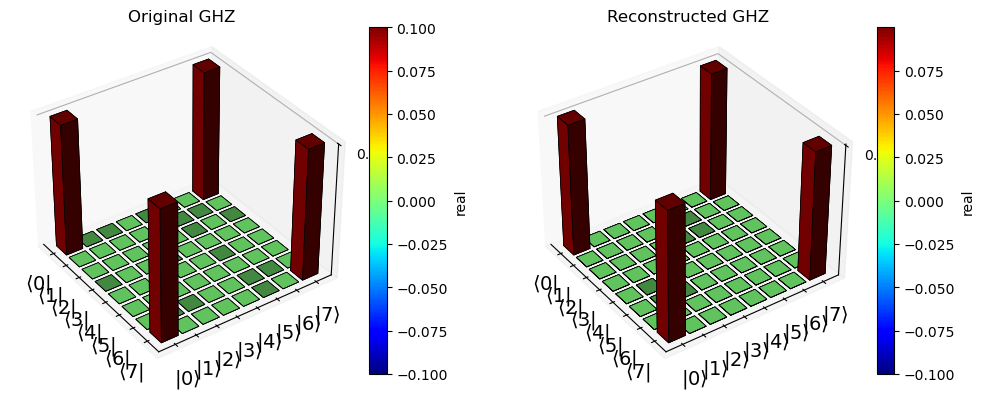

In [10]:
rho_ghz = tensor(ghz_state, ghz_state.dag())

fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={"projection": "3d"})

# Plot the first matrix histogram
matrix_histogram(rho_ghz, ax=axes[0])
axes[0].set_title("Original GHZ")

# Plot the second matrix histogram
matrix_histogram(rho_gd_proj, ax=axes[1])
axes[1].set_title("Reconstructed GHZ")

# Show the plots
plt.show()

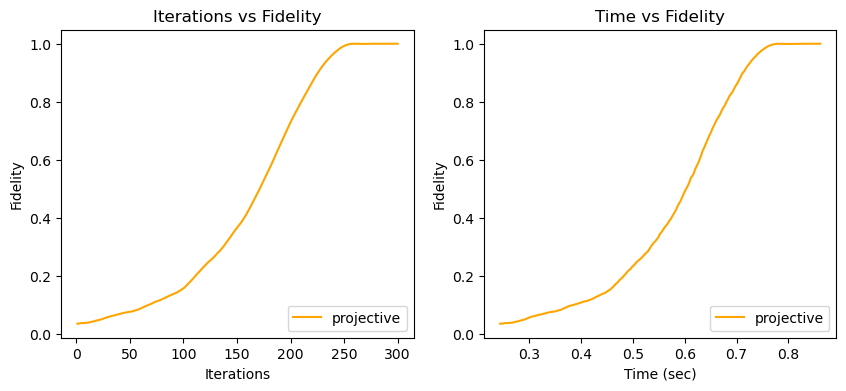

In [11]:
fid_list_proj = np.array(fid_list_proj)
mean_fid_proj = np.mean(fid_list_proj, axis=0)
time_list_proj = np.array(time_list_proj)
mean_time_proj = np.mean(time_list_proj, axis=0)


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))


###-------------Fidelity Vs iterations -------------#######

ax1.set_title("Iterations vs Fidelity", fontsize=12)

iterations = np.arange(1,len(f_gd_proj)+1)   # total number of iterations

ax1.plot(iterations, mean_fid_proj, color='orange',label="projective")

ax1.legend(loc='lower right')
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Fidelity")


###-------------Fidelity Vs time -------------#######

ax2.set_title("Time vs Fidelity", fontsize=12)


ax2.plot(mean_time_proj, mean_fid_proj, color='orange',label="projective")


ax2.legend(loc='lower right')
ax2.set_xlabel("Time (sec)")
ax2.set_ylabel("Fidelity")

plt.show()